In [1]:
#!/usr/bin/env python3

In [2]:
%matplotlib inline
import numpy as np 
import time 
from datetime import timedelta
import tensorflow as tf
from readImages import *
from build_tensorflow_graph import *
import matplotlib.pyplot as plt
import random
import joblib

In [3]:
def nextEpoch(imgs, batch_size = 128):
    imgs = random.sample(imgs, len(imgs))
    
    numBatches = len(imgs) // batch_size
    for i in range(numBatches):
        yield imgs[i*batch_size : (i+1)*batch_size]
    

In [4]:
#
## ---------- DCGAN Architecture ----------
#

numFilters1 = 32
numFilters2 = 64
numFilters3 = 128
numFilters4 = 256

strides = 2
# Convolution Layer 1
cnnArchitecture1 = CNN_Architecture(numFilters = numFilters1, 
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = 3, 
                                    maxPoolingSize=None)

dcnnArchitecture1 = CNN_Architecture(numFilters = 3, 
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters1, 
                                    maxPoolingSize=None)

# Convolution Layer 2
cnnArchitecture2 = CNN_Architecture(numFilters = numFilters2, 
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters1, 
                                    maxPoolingSize=None)
dcnnArchitecture2 = CNN_Architecture(numFilters = numFilters1, 
                                    filterSize = (3, 3), 
                                    strides = strides,
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters2, 
                                    maxPoolingSize=None)

# Convolution Layer 3
cnnArchitecture3 = CNN_Architecture(numFilters = numFilters3,
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters2, 
                                    maxPoolingSize=None)
dcnnArchitecture3 = CNN_Architecture(numFilters = numFilters2,
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters3, 
                                    maxPoolingSize=None)

# Convolution Layer 4
cnnArchitecture4 = CNN_Architecture(numFilters = numFilters4,
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters3, 
                                    maxPoolingSize=None)
dcnnArchitecture4 = CNN_Architecture(numFilters = numFilters3,
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters4, 
                                    maxPoolingSize=None)

# Fully Connected 1
fc5_size = 1024 

# Lattern Code 
z_dim = 256

# flattern size
flat_size = 4096

In [5]:
class Image:
    size = 64
    channels = 3

<div>
<h1>Network Output Size</h1>
    <p>
    <ul>
        <li>Input Layer: 64 * 64 * 3 = 12288</li>
        <li>Convolutional Layer1: 32 * 32 * 32 = 32768 </li>
        <li>Convolutional Layer2: 16 * 16 * 64 = 16384 </li>
        <li>Convolutional Layer3: 8 * 8 * 128 = 8192 </li>
        <li>Convolutional Layer4: 4 * 4 * 256 = 4096 </li>
        <li>Fully Connected Layer5: 1024 </li>
        <li>Latten Code: 256 </li>
    </ul>
    </p>
</div>


In [6]:
class DCGAN:
    """
    """
    def __init__(self, batch_size, lr_g=1e-3, lr_d=1e-4):
        self.lr_g = lr_g
        self.lr_d = lr_d
        self.batch_size = batch_size
        self.sess = tf.Session()
        
        self.build_model()
        
    def build_model(self):
        # ---------- 1. placeholder ----------
        self.lattenCode = tf.placeholder(tf.float32, shape = [None, z_dim])
        self.inputImages = tf.placeholder(tf.float32, shape = [None, Image.size, Image.size, Image.channels])
        
        # ---------- 2. Discriminator & generator ----------
        self.discriminate_true = self.build_discriminator(self.inputImages, is_training = True, 
                                                          reuse = False, init_stdev = 0.02)
        
        self.generatedImgs = self.build_generator(self.lattenCode, is_training = True, bs = self.batch_size, 
                                                  reuse = False, init_stdev = 0.02)
        
        self.discriminate_fake = self.build_discriminator(self.generatedImgs, is_training = True, 
                                                         reuse = True, init_stdev = 0.02)
        # ---------- 3. Cost Function & Optimizer ----------
        # Discriminator loss 
#         discriminator_true_loss = tf.log(self.discriminate_true + 1e-8)
#         discriminator_fake_loss = tf.log(1 - self.dicriminate_fake + 1e-8)
#         discriminator_reward = tf.reduce_mean(discriminator_true_loss + discriminator_fake_loss)
#         self.discriminator_loss = -1.0 * discriminator_reward
                
        discriminator_true_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.discriminate_true, 
                                                                           labels= tf.ones_like(self.discriminate_true)))
        discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.discriminate_fake, 
                                                                          labels = tf.zeros_like(self.discriminate_fake)))
        self.discriminator_loss = (discriminator_true_loss + discriminator_fake_loss) * 0.5 
        
        
        # Generator Loss 
#         self.generator_loss = tf.reduce_mean(-tf.log(self.discriminate_fake + 1e-8))
        self.generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.discriminate_fake, 
                                                                            labels = tf.ones_like(self.discriminate_fake)))
        
        # Optimizer 
        all_vars = tf.trainable_variables()
        d_vars = [var for var in all_vars if 'discriminator' in var.name]
        g_vars = [var for var in all_vars if 'generator' in var.name]
        
        ## For Testing
#         d_names = [v.name for v in d_vars]
#         g_names = [v.name for v in g_vars]
#         print('d_names:', d_names)
#         print('g_names', g_names)
        
        self.generator_optimizer = tf.train.AdamOptimizer(self.lr_g, beta1=0.5).minimize(self.generator_loss, var_list=g_vars)
        self.discriminator_optimizer = tf.train.AdamOptimizer(self.lr_d, beta1=0.5).minimize(self.discriminator_loss, var_list=d_vars)

#         self.generator_optimizer = tf.train.RMSPropOptimizer(self.lr_g).minimize(self.generator_loss, var_list=g_vars)
#         self.discriminator_optimizer = tf.train.RMSPropOptimizer(self.lr_d).minimize(self.discriminator_loss, var_list=d_vars)
        
#         self.generator_optimizer = tf.contrib.opt.NadamOptimizer(self.lr_g).minimize(self.generator_loss, var_list=g_vars)
#         self.discriminator_optimizer = tf.contrib.opt.NadamOptimizer(self.lr_d).minimize(self.discriminator_loss, var_list=d_vars)
        
        # ---------- 4. build Testing Model ----------
        self.numGenerates = 64
        self.fake_images = self.build_generator(self.lattenCode, is_training = False, reuse = True, 
                                                bs = self.numGenerates, init_stdev = 0.02)
        # --------- 5. Model Saver ----------
        self.saver = tf.train.Saver()
            
    def build_discriminator(self, inputLayer, is_training = True, reuse = False, init_stdev = 0.01):
        """
        Arg:
        -------------------------------------------------------------------------
          * inputLayer [tensor] shape = (batch, height, width, channel).
          
        """
        with tf.variable_scope("discriminator", reuse = reuse):
            # Convolutional Layers
            conv1, _ = new_convLayer(inputLayer, cnnArchitecture1, name = "dis_conv1", stdev = init_stdev)
            conv1 = lrelu(bn(conv1, is_training = is_training, scope = "dis_bn1"))
            conv2, _ = new_convLayer(conv1, cnnArchitecture2, name = "dis_conv2", stdev = init_stdev)
            conv2 = lrelu(bn(conv2, is_training = is_training, scope = "dis_bn2"))
            conv3, _ = new_convLayer(conv2, cnnArchitecture3, name = "dis_conv3", stdev = init_stdev)
            conv3 = lrelu(bn(conv3, is_training = is_training, scope = "dis_bn3"))
            conv4, _ = new_convLayer(conv3, cnnArchitecture4, name = "dis_conv4", stdev = init_stdev)
            conv4 = lrelu(bn(conv4, is_training = is_training, scope = "dis_bn4"))
            
#             ## for testing
#             _, nodes1 = flattenLayer(conv1)
#             _, nodes2 = flattenLayer(conv2)
#             _, nodes3 = flattenLayer(conv3)
#             _, nodes4 = flattenLayer(conv4)
#             nodess = [nodes1, nodes2, nodes3, nodes4]
#             for i in range(1, 5): 
#                 print('#nodes in conv{}: {}'.format(i, nodess[i - 1]))
            
            # Flattern
            flat, numNodes = flattenLayer(conv4)
#             assert numNodes == flat_size, "Something wrong while flatterning ... {} != {}".format(numNodes, flat_size)
            self.flat_size = numNodes
            
            # Fully Connected Layers
            fc5 = new_fcLayer(flat, numNodes, fc5_size, useReLU=False, name="dis_fc5", stdev=init_stdev)
            fc5 = lrelu(bn(fc5, is_training = is_training, scope = "dis_bn5"))
            output = new_fcLayer(fc5, fc5_size, 1, useReLU=False, name="dis_out", stdev=init_stdev)
            output = tf.nn.sigmoid(output)
            
            return output
            
    
    def build_generator(self, inputLayer, is_training = True, bs = None, reuse = False, init_stdev = 0.01):
        if bs is None:
            bs = self.batch_size
            
        with tf.variable_scope("generator", reuse = reuse):
            # de fully connected layers
            fc1 = new_fcLayer(inputLayer, z_dim, fc5_size, useReLU=True, name="gen_fc1", stdev=init_stdev)
            fc1 = lrelu(bn(fc1, is_training = is_training, scope = "gen_bn1"))
            fc2 = new_fcLayer(fc1, fc5_size, self.flat_size, useReLU=True, name="gen_dconv2", stdev=init_stdev)
            fc2 = lrelu(bn(fc2, is_training = is_training, scope = "gen_bn2"))
            
            # Reshaping
            conv2 = tf.reshape(fc2, shape=[-1, 4, 4, numFilters4])
            
            # Convolutional Layers
            conv3 = new_dconvLayer(conv2, dcnnArchitecture4, outputShape = [bs, Image.size // 8, Image.size // 8, numFilters3], 
                                   name = "gen_dconv3", stdev = init_stdev)
            conv3 = lrelu(bn(conv3, is_training = is_training, scope = "gen_bn3"))
            
            conv4 = new_dconvLayer(conv3, dcnnArchitecture3, outputShape = [bs, Image.size // 4, Image.size // 4, numFilters2], 
                                   name = "gen_dconv4", stdev = init_stdev)
            conv4 = lrelu(bn(conv4, is_training = is_training, scope = "gen_bn4"))
            
            conv5 = new_dconvLayer(conv4, dcnnArchitecture2, outputShape = [bs, Image.size // 2, Image.size // 2, numFilters1], 
                                   name = "gen_dconv5", stdev = init_stdev)
            conv5 = lrelu(bn(conv5, is_training = is_training, scope = "gen_bn5"))
            
            image = new_dconvLayer(conv5, dcnnArchitecture1, outputShape = [bs, Image.size, Image.size, Image.channels], 
                                   name = "gen_image", stdev = init_stdev)
            image = tf.nn.sigmoid(image)
            
            return image
            
            
    def train(self, fileDir, epochs = 100, saveModel = False, k = 1, restorePath=None, monitor=0):
        generator_lossHistory = []
        discriminator_lossHistory = []
        
        print('  * Start Training {:>3} epochs ...'.format(epochs))
        if not restorePath:
            print('\t- initializing network ...')
            self.sess.run(tf.global_variables_initializer())
        else:
            self.saver.restore(self.sess, restorePath)
            print("\t- model '{}' restored.".format(restorePath))
        
        all_imgs = joblib.load('../all_images.pkl')
        for epoch in range(epochs):
            print('    * processing epoch #{} '.format(epoch+1))
            count = 0
#             for batch in readImagesIn(directory=fileDir, size=(Image.size, Image.size),
#                                            noiseStdev=0.0, batch_size = (self.batch_size)*k ):
            for batch in nextEpoch(all_imgs, batch_size = (self.batch_size)*k):
                count += 1
                # ----------- Train Discriminator k times ----------
                for i in range(k):
                    batch_imgs = batch[i*self.batch_size :(i+1)*self.batch_size]
                    batch_z = np.random.normal(0.0, 1.0, [self.batch_size, z_dim])
                    
                    feed_dict_discriminator = {self.lattenCode : batch_z, self.inputImages : batch_imgs}  

                    _, d_loss = self.sess.run([self.discriminator_optimizer, self.discriminator_loss],
                                               feed_dict = feed_dict_discriminator)
                # append loss every k times => ez to plot
                discriminator_lossHistory.append(d_loss)
                
                # ---------- Train Generator 1 time ----------
                batch_z = np.random.normal(0, 1, [self.batch_size, z_dim])
                feed_dict_generator = {self.lattenCode : batch_z}
                
                _, g_loss = self.sess.run([self.generator_optimizer, self.generator_loss], 
                                          feed_dict = feed_dict_generator)
                generator_lossHistory.append(g_loss)
                
                
                # ---------- Print Loss every t times ----------
                if count % 100 == 1:
                    print('\tepoch #{:>3d}, iterations #{:>5d}, g_loss = {:>.5f}, d_loss = {:>.5f}'.format(epoch+1, 
                                                                                              count, g_loss, d_loss))
            print('    ---------------------------------------------------------------------')       
            print('\t- DONE!  g_loss = {:>.5f}, d_loss = {:>.5f}'.format(g_loss, d_loss))
            ## TODO...
            # Dst tensor is not initialized Error while saving model
            if saveModel:
                save_path = self.saver.save(self.sess, "../models/DCGAN/dcgan.ckpt")
                print("\t- Model saved in path: %s" % save_path)
            if monitor > 0 and (epoch % monitor == 0):
                imgs = self.generateFakeImages(self.numGenerates)
                plotImages(imgs, savePath = '../figure/DCGAN/generate_monitor_' + str(epoch) + '.png')
            print()
            
        del all_imgs
        
        return (discriminator_lossHistory, generator_lossHistory)
        
    def save(self, path):
        raise NotImplementedError
        
    def load(self, path):
        self.saver.restore(self.sess, path)
        print("\t- model '{}' restored.".format(path))
        
    def generateFakeImages(self, numImgs):
        z = np.random.normal(0, 1, size=(self.numGenerates, z_dim))
        feed_dict_test = {self.lattenCode : z }
        fakeImg = self.sess.run(self.fake_images, feed_dict=feed_dict_test)
        return fakeImg
        

In [7]:
def avg(x, window_len):
    numAvgs = math.ceil(len(x) / float(window_len))
    
    avgs = []
    for i in range(numAvgs):
        start = i * window_len
        end = (i+1) * window_len if i < numAvgs - 1 else len(x)
        
        avgs.append(sum(x[start:end]) / float(window_len))
        
    return avgs

  * Building Model ...  Finished!!
  * Start Training 100 epochs ...
	- initializing network ...
    * processing epoch #1 
	epoch #  1, iterations #    1, g_loss = 0.45867, d_loss = 0.73284
	epoch #  1, iterations #  101, g_loss = 0.63833, d_loss = 0.56827
    ---------------------------------------------------------------------
	- DONE!  g_loss = 0.67073, d_loss = 0.53700
	- Model saved in path: ../models/DCGAN/dcgan.ckpt

    * processing epoch #2 
	epoch #  2, iterations #    1, g_loss = 0.67375, d_loss = 0.54689
	epoch #  2, iterations #  101, g_loss = 0.68802, d_loss = 0.52399
    ---------------------------------------------------------------------
	- DONE!  g_loss = 0.67489, d_loss = 0.54320
	- Model saved in path: ../models/DCGAN/dcgan.ckpt

    * processing epoch #3 
	epoch #  3, iterations #    1, g_loss = 0.67811, d_loss = 0.53248
	epoch #  3, iterations #  101, g_loss = 0.67802, d_loss = 0.52592
    ---------------------------------------------------------------------
	- D

C:\Users\tea\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


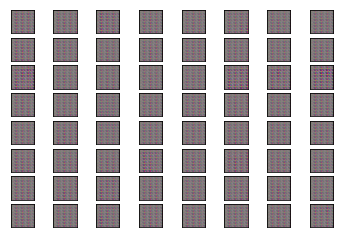

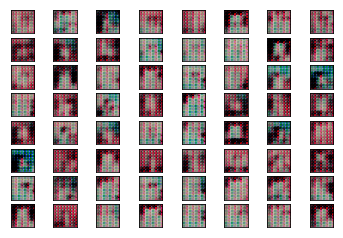

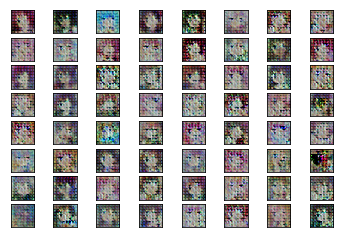

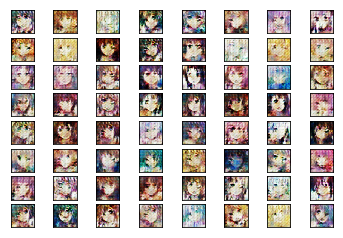

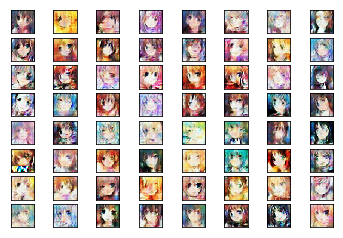

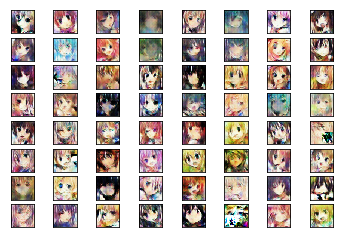

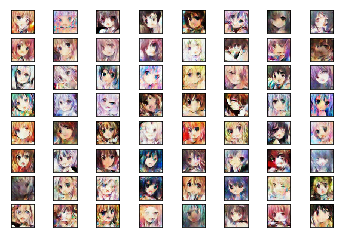

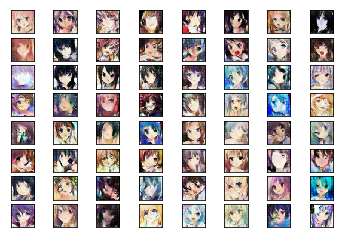

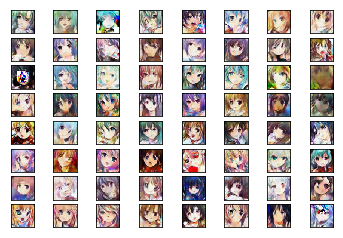

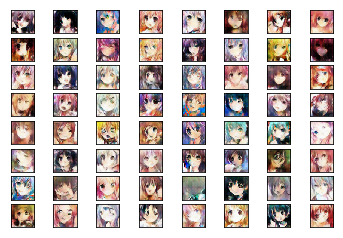

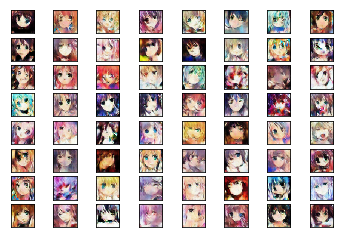

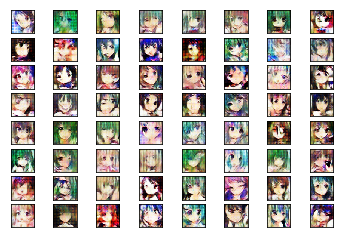

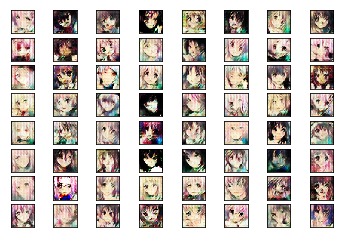

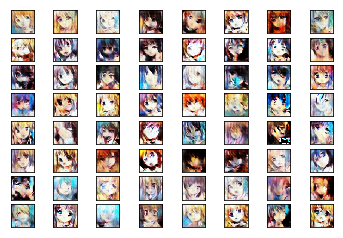

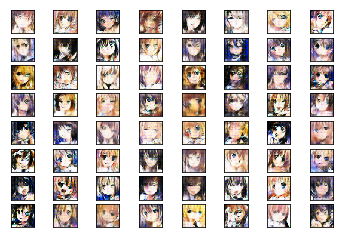

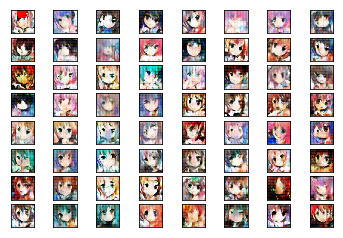

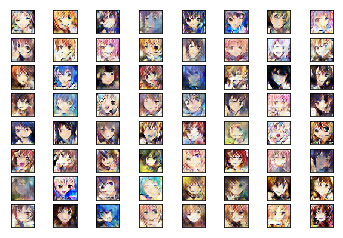

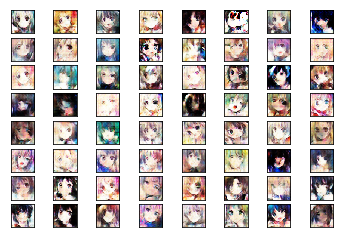

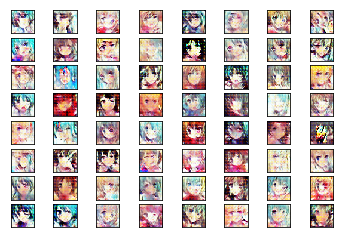

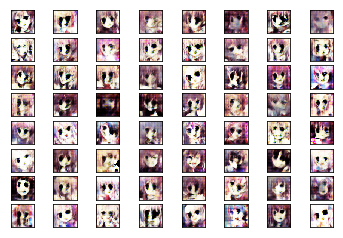

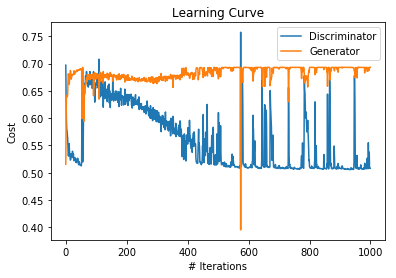

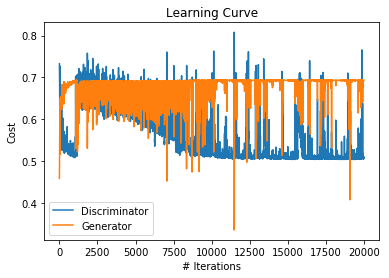

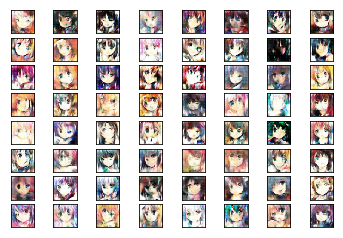

In [8]:
if __name__ == '__main__':
#     directory = '../data/'
    directory = '../faces/'
    batch_size = 256
    
    print('  * Building Model ...', end="")
    dc_gan = DCGAN(batch_size = batch_size, lr_g=1*1e-3, lr_d=2*1e-4)
    print('  Finished!!')

    toRestore = False
    restorePath = "../models/DCGAN/dcgan.ckpt" if toRestore else None
    epochs = 100

    discriminator_lossHistory, generator_lossHistory = dc_gan.train(fileDir=directory, epochs = epochs, saveModel = True,
                                                                    k = 1,  restorePath=restorePath, monitor=5)

    # -------- Plot Learning Curve --------
    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel('# Iterations')
    plt.ylabel('Cost')
    plt.plot(avg(discriminator_lossHistory, 20), label="Discriminator")
    plt.plot(avg(generator_lossHistory, 20), label="Generator")
    plt.legend(loc = 'best')
    plt.savefig('../figure/DCGAN/LearningCurve.png')
    
    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel('# Iterations')
    plt.ylabel('Cost')
    plt.plot((discriminator_lossHistory), label="Discriminator")
    plt.plot((generator_lossHistory), label="Generator")
    plt.legend(loc = 'best')
    plt.savefig('../figure/DCGAN/LearningCurve_raw.png')
    
    #
    ## ---------- Fake Images ----------
    #

#     z = np.random.normal(0, 1, size=(dc_gan.numGenerates, z_dim))
#     # z = np.random.uniform(-5, 5, size=(batch_size, z_dim))
#     feed_dict_test = {dc_gan.lattenCode : z }
#     imgs = dc_gan.sess.run(dc_gan.fake_images, feed_dict=feed_dict_test)
    imgs = dc_gan.generateFakeImages(dc_gan.numGenerates)
    plotImages(imgs, savePath = '../figure/DCGAN/generate1.png')

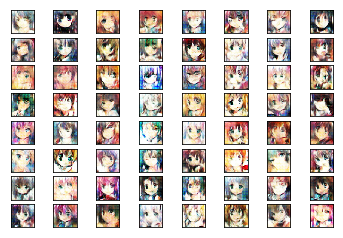

In [9]:
#
## ---------- Fake Images ----------
#

z = np.random.normal(0, 1, size=(dc_gan.numGenerates, z_dim))
# z = np.random.uniform(-5, 5, size=(batch_size, z_dim))
feed_dict_test = {dc_gan.lattenCode : z }
imgs = dc_gan.sess.run(dc_gan.fake_images, feed_dict=feed_dict_test)
# imgs = dc_gan.generateFakeImages(dc_gan.numGenerates)
plotImages(imgs, savePath = '../figure/DCGAN/generate1.png')